In [1]:
!pip install torch torchvision onnx onnxruntime scikit-learn matplotlib pillow tqdm --quiet


In [13]:
#Data set preparation 
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torchvision

In [15]:
DATA_DIR= r"C:\Users\jyoth\OneDrive\Documents\scrap classification\dataset-resized"
BATCH_SIZE = 32
IMG_SIZE = 224
VAL_SPLIT = 0.2
SEED = 42
learning_rate = 1e-3
EPOCHS = 5

torch.manual_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [17]:
import os

print("Inside DATA_DIR:", os.listdir(DATA_DIR))
for folder in os.listdir(DATA_DIR):
    path = os.path.join(DATA_DIR, folder)
    if os.path.isdir(path):
        print(folder, "-> sample files:", os.listdir(path)[:3])

Inside DATA_DIR: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
cardboard -> sample files: ['cardboard1.jpg', 'cardboard10.jpg', 'cardboard100.jpg']
glass -> sample files: ['glass1.jpg', 'glass10.jpg', 'glass100.jpg']
metal -> sample files: ['metal1.jpg', 'metal10.jpg', 'metal100.jpg']
paper -> sample files: ['paper1.jpg', 'paper10.jpg', 'paper100.jpg']
plastic -> sample files: ['plastic1.jpg', 'plastic10.jpg', 'plastic100.jpg']
trash -> sample files: ['trash1.jpg', 'trash10.jpg', 'trash100.jpg']


In [19]:
#  Dataset Preparation
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

transform_test = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])
transform_val = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])
dataset = datasets.ImageFolder(DATA_DIR, transform=transform_train)
class_names = dataset.classes
print("Classes:", class_names)

Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [59]:
full_dataset = torchvision.datasets.ImageFolder(root=DATA_DIR)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
torch.manual_seed(42)

train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size],generator=torch.Generator().manual_seed(42))

val_ds.dataset.transform = transform_val
test_ds.dataset.transform = transform_test
train_ds.dataset.transform = transform_train

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,num_workers=4,shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE,num_workers=4, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE,num_workers=4,shuffle=False)

Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Train size: 2021, Validation size: 252


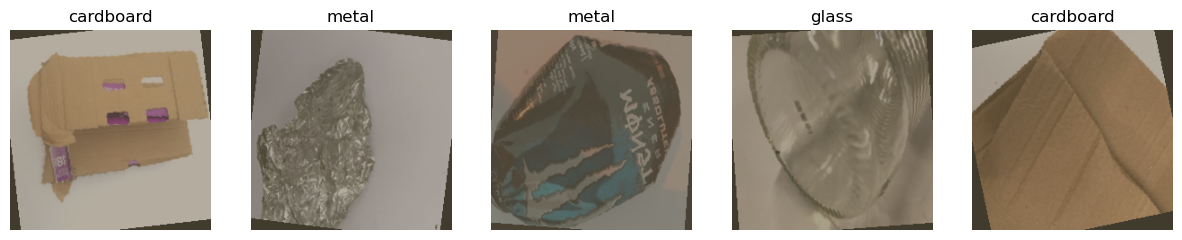

In [61]:
#  Inspect Data
classes = dataset.classes
print(f"Classes: {classes}")
print(f"Train size: {train_size}, Validation size: {val_size}")

# Show sample batch
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = images[i].permute(1, 2, 0).numpy()
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # de-normalize
    axes[i].imshow(img.clip(0, 1))
    axes[i].set_title(classes[labels[i]])
    axes[i].axis("off")
plt.show()


In [27]:
#  Model Setup
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
# Ensure directories exist
os.makedirs(r"C:\Users\jyoth\OneDrive\Documents\my_models", exist_ok=True)

In [31]:
train_losses, val_accs = [], []
best_acc = 0
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation MUST be here inside the loop
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    acc = 100 * correct / total
    val_accs.append(acc)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {train_losses[-1]:.4f}, Val Acc: {acc:.2f}%")
    model_path=r"C:\Users\jyoth\OneDrive\Documents\my_models\resnet18_trashnet.pth"
    # Save best model
    if acc > best_acc:
        torch.save(model.state_dict(), model_path)
        best_acc = acc

Epoch 1/5, Loss: 0.9607, Val Acc: 68.25%
Epoch 2/5, Loss: 0.8108, Val Acc: 69.84%
Epoch 3/5, Loss: 0.7246, Val Acc: 72.22%
Epoch 4/5, Loss: 0.6968, Val Acc: 76.98%
Epoch 5/5, Loss: 0.6364, Val Acc: 75.40%


In [63]:
#  Evaluation on Test Set
os.makedirs(r"C:\Users\jyoth\OneDrive\Documents\my_models", exist_ok=True)
model_path = r"C:\Users\jyoth\OneDrive\Documents\\resnet18_trashnet_test.pth"
torch.save(model.state_dict(), model_path)
model.load_state_dict(torch.load(r"C:\Users\jyoth\OneDrive\Documents\\resnet18_trashnet_test.pth"))
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, target_names=class_names)

results_dir = r"C:\Users\jyoth\OneDrive\Documents\my_results"
os.makedirs(results_dir, exist_ok=True)
report_path = os.path.join(results_dir, "classification_report.txt")

# Save to text file
with open(report_path, "w") as f:
    f.write(report)
print(f"Classification report saved at: {report_path}")


Classification report saved at: C:\Users\jyoth\OneDrive\Documents\my_results\classification_report.txt


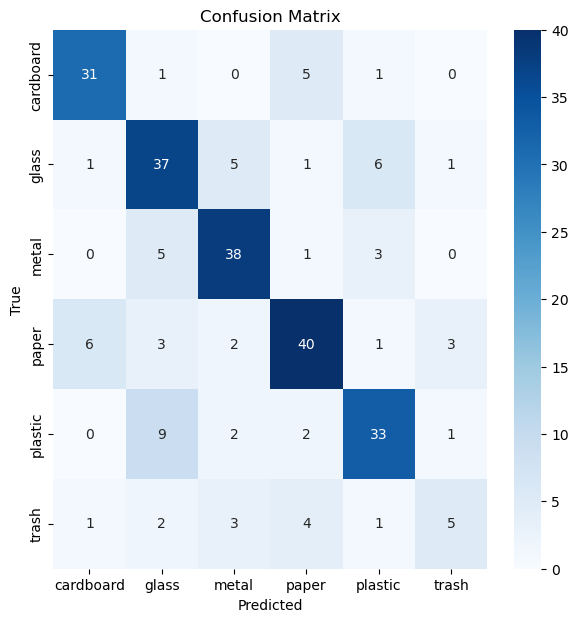

In [65]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(r"C:\Users\jyoth\OneDrive\Documents\my_results\confusion_matrix.png")
plt.show()

In [89]:
val_losses = []
model.eval()
for epoch in range(EPOCHS):
    val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad(): 
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Compute accuracy
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}, Validation Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch 1/5, Validation Loss: 0.6716, Val Acc: 76.19%
Epoch 2/5, Validation Loss: 0.6668, Val Acc: 76.59%
Epoch 3/5, Validation Loss: 0.6500, Val Acc: 76.98%
Epoch 4/5, Validation Loss: 0.6832, Val Acc: 72.62%
Epoch 5/5, Validation Loss: 0.6882, Val Acc: 76.59%


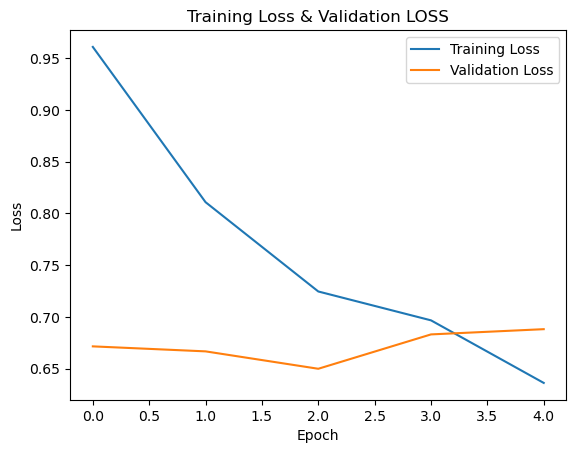

In [91]:
#  Training Curves
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss & Validation LOSS")
plt.savefig(r"C:\Users\jyoth\OneDrive\Documents\my_results\training_curves.png")
plt.show()

In [114]:
import onnxruntime as ort
import numpy as np
from PIL import Image
from torchvision import transforms
from pathlib import Path

train_dir = r"C:\Users\jyoth\OneDrive\Documents\scrap classification\dataset-resized"
class_names = sorted([p.name for p in Path(train_dir).iterdir() if p.is_dir()])
print("Class order:", class_names)

# Load ONNX model
onnx_path = r"C:\Users\jyoth\OneDrive\Documents\my_results\scrap_model.onnx"
ort_session = ort.InferenceSession(onnx_path)
# Image preprocessing
mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def preprocess_image(img_path, img_size=224):
    img = Image.open(img_path).convert("RGB").resize((img_size, img_size))
    img_np = np.array(img).astype(np.float32) / 255.0
    img_np = (img_np - mean) / std
    img_np = img_np.transpose(2,0,1)   # [C,H,W]
    img_np = np.expand_dims(img_np, axis=0)  # [1,C,H,W]
    return img_np


# 4️Prediction
CONF_THRESHOLD = 0.6  
def predict_image_onnx(img_path):
    x = preprocess_image(img_path).astype(np.float32)
    input_name = ort_session.get_inputs()[0].name
    output_name = ort_session.get_outputs()[0].name

    ort_outs = ort_session.run([output_name], {input_name: x})[0]  # [1, num_classes]
    
    # Softmax probabilities
    exp_out = np.exp(ort_outs - np.max(ort_outs, axis=1, keepdims=True))
    probs = exp_out / np.sum(exp_out, axis=1, keepdims=True)
    
    # Top-2 predictions
    top2_idx = np.argsort(probs[0])[::-1][:2]
    top2 = [(class_names[i], probs[0, i]*100) for i in top2_idx]

    pred_idx = top2_idx[0]
    conf = top2[0][1]
    predicted_class = class_names[pred_idx]

    low_conf = conf < (CONF_THRESHOLD*100)
    return predicted_class, conf, low_conf, top2


# 5️ Test example
test_image = r"C:\Users\jyoth\OneDrive\Documents\scrap classification\dataset-resized\paper\paper1.jpg"
pred_class, conf, low_conf, top2 = predict_image_onnx(test_image)

print(f"[ONNX] Predicted Class: {pred_class} | Confidence: {conf:.2f}%")
if low_conf:
    print(" Low confidence prediction")
print("Top-2 predictions:", top2)


Class order: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
[ONNX] Predicted Class: paper | Confidence: 72.07%
Top-2 predictions: [('paper', 72.06746935844421), ('plastic', 14.556975662708282)]


In [118]:
import os, shutil
from pathlib import Path
import random
dataset_root = r"C:\Users\jyoth\OneDrive\Documents\scrap classification\dataset-resized"
frames_folder = r"C:\Users\jyoth\OneDrive\Documents\my_results\frames"

os.makedirs(frames_folder, exist_ok=True)

N = 10

for class_dir in Path(dataset_root).iterdir():
    if class_dir.is_dir():
        images = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.png"))
        if not images:
            continue
        sample_images = random.sample(images, min(N, len(images)))
        
        for img in sample_images:
            dest = Path(frames_folder) / f"{class_dir.name}_{img.name}"
            shutil.copy(img, dest)

print(f" Collected {N} images per class into {frames_folder}")


import csv, time, os
from datetime import datetime
results_csv = r"C:\Users\jyoth\OneDrive\Documents\my_results\conveyor_logs.csv"

def ensure_csv(path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    if not os.path.exists(path):
        with open(path, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(["timestamp", "frame", "predicted", "confidence", "low_confidence", "top2"])

def simulate_conveyor(folder, fps=1):
    ensure_csv(results_csv)
    files = sorted(Path(folder).glob("*.jpg")) + sorted(Path(folder).glob("*.png"))

    print(f"Starting conveyor simulation on {len(files)} frames...")

    for f in files:
        ts = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

        # Prediction
        pred_class, conf, low_conf, top2 = predict_image_onnx(str(f))

        with open(results_csv, "a", newline="") as logf:
            writer = csv.writer(logf)
            writer.writerow([ts, f.name, pred_class, f"{conf:.2f}", low_conf, top2])
        time.sleep(1/fps)

# Run simulation on your dataset frames folder
frames_folder = r"C:\Users\jyoth\OneDrive\Documents\my_results\frames"
simulate_conveyor(frames_folder, fps=1)  


 Collected 10 images per class into C:\Users\jyoth\OneDrive\Documents\my_results\frames
Starting conveyor simulation on 231 frames...
